# Logistische Regression (Aufgaben)
Die lineare Regression findet eine Linearkombination der Eingangsdaten, die die Zieldaten gut approximiert. Mit Hilfe der logistischen Regressionen können auch nicht-lineare Abbildungen gefunden werden. Außerdem eignet sie sich um binäre Aussagen zu treffen. Die heutige Übung verwendet das MNIST Datenset von Yann LeCun, welches Bilder von handgeschriebenen Ziffern beinhaltet. Ein Model der logistische Regression soll mit diesen Daten trainiert und im Anschluss getestet werden. Das fertige System soll in der Lage sein, die Ziffer auf einen unbekannten Bild zu benennen.

Dieses Jupyter Notebook steht wieder zum Download bereit.

## Vorbereitung
Es ist sinnvoll zunächst die Lineare Regression 2D in eine vektorisierte Variante zu überführen um diesen Ansatz anhand eines Beispiels zu lernen, welches bereits bekannt ist. Die Vektoren/Matrizen-Schreibweise ist für die nachfolgende Übung unabdiengbar. Die Idee ist es alle Berechnungen (Prediction, Error usw) ohne for-loops auszurechnen. Das gilt ebenfalls für die partiellen Ableitungen, die mit einer Matrix Multiplikation gelöst werden können. Auf diese Weise sind beliebig hochdimensionale Eingangdaten verarbeitbar.

## Einleitung
Scikit-learn liefert eine Methode um die MNIST Daten aus dem Internet zu laden. Die erhaltenden Daten teilen wir in Test und Trainingsdaten auf. Wobei wir darauf achten, die Daten vorher zu mischen.

In [1]:
!pip install deep-teaching-commons

In [2]:
from shutil import copyfileobj
from sklearn.datasets.base import get_data_home
from deep_teaching_commons.data.fundamentals import mnist

import os
import urllib
from sklearn.utils import check_random_state

X_train, y_train, X_test, y_test = mnist.Mnist().get_all_data(normalized=False)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# only shuffle train dataset
random_state = check_random_state(0)
permutation = random_state.permutation(X_train.shape[0])
X_train = X_train[permutation]
y_train = y_train[permutation]

auto download is active, attempting download
mnist data directory already exists, download aborted
(60000, 784) (60000,)
(10000, 784) (10000,)


## Daten Visualisierung

Visualisieren sie von jeder Ziffer 5 Bilder in einem 10x5 großen Raster. Die Ziffern liegen als 28x28 Pixel große Graustufenbildern vor. Jede Zeile von x representiert eine Zahl. Ist der Zeilenindex bekannt, kann die Zeile mit numpy.take(...) extrahiert werden.




In [3]:
import matplotlib.pyplot as plt
import numpy as np

# enable interactive plots
%matplotlib notebook

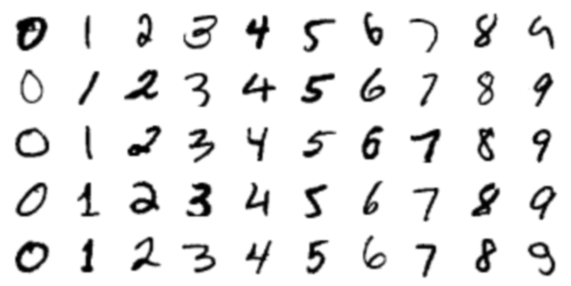

In [4]:
# TODO Plots 50 images in a 10x5 grid. 
def plot_mnist_digits(data, examples_each_row):
    plt.figure(figsize=(10, examples_each_row))
    num_classes = 10
    X, y = data
    
    for c in range(num_classes):
        # Select samples_per_class random keys of the labels == current class
        keys = np.random.choice(np.where(y == c)[0], examples_each_row)
        images = X[keys]
        for i in range(examples_each_row):
            f = plt.subplot(examples_each_row, num_classes,
                            i * num_classes + c + 1)
            f.axis('off')
            plt.imshow(
                images[i].reshape(28, 28),
                cmap='binary',
                interpolation='bicubic')


plot_mnist_digits([X_train, y_train], examples_each_row=5)
plt.show()

## Daten Normalisierung und hinzufügen von Bias

Solange wie die Eingangsdaten (x_train, x_test) in einem Regressions-Model normalisiert sind, können Lernraten zwischen 0.1 und 1.0 verwendet werden. Ändert sich der Wertebereich dieser Daten, werden komplett andere Learnraten benötigt. Es ist also sinnvoll die Daten immer vorher zwischen 0 und 1 zu normalisieren. Außerdem sollten hier gleich die Bias Units an die Daten hinzugefügt werden.



In [5]:
# TODO Normalize the data.
X_train = X_train / 255
X_test = X_test / 255
print(np.max(X_train), np.min(X_train))
# Bias 
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])

1.0 0.0


<hr />
<h2>One-Hot-Encoding</h2>

<p>Die logistische Regression liefert als Ergebniswerte zwischen 0 und 1. Damit ist&nbsp;zun&auml;chst keine Multi-Klassen Klassifikation m&ouml;glich, die f&uuml;r das MNIST Beispiel aber notwendig ist. Deswegen m&uuml;ssen die Zieldaten (y_train, y_test) mit dem One-vs-All Ansatz oder auch One-Hot-Encoding genannt transformiert werden. Das Ergebnis sind&nbsp;y_train und y_test Matrizen im Shape von 60000x10 bzw. 10000x10.&nbsp;</p>


In [6]:
from sklearn.preprocessing import OneHotEncoder


# Support function to convert label vector into a one hot encoding matrix
def onehot_encode_label(label):
    onehot_encoder = OneHotEncoder(sparse=False)
    label = label.reshape(len(label), 1)
    onehot_encoded_label = onehot_encoder.fit_transform(label)
    return onehot_encoded_label


y_train, y_test = onehot_encode_label(y_train), onehot_encode_label(y_test)
print('train label shape', y_train.shape)
print('test label shape', y_test.shape)

train label shape (60000, 10)
test label shape (10000, 10)


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

## Training
Nutzen sie die logistischen Regression um ein Model zu trainieren welches für ein 28x28 Pixel-Bild die darauf befindliche Ziffer vorhersagt. Notieren sie sich den Trainingsfehler bezüglich der Trainings- und Testdaten sowie die Vorhersagegenautigkeit mit Hilfe der Testdaten. Die Regression liefert für alle eingehenden Daten jeweils einen Vektor mit 10 Dimensionen. Die Dimension die den höchsten Wert liefert, gilt als Gewinner und wird verglichen mit der identischen Dimension im One-Hot-Vektors. Auf diese Weise lässt sich ermitteln, wie häufig die Regression richtig lag (Vorhersagegenauigkeit).

Wird die Differenz zwischen den beiden Vektoren ermittelt, können mit Hilfe der partiellen Ableitung die Gewichts-/Theta-Werte angepasst werden, sodass in Zukunft die Differenz kleiner ausfällt. Außerdem ist es möglich, den Mean-Squared-Error der Trainingsdaten anhand dieser Differenz auszurechnen (Trainingsfehler).

In [7]:
# TODO Build a logist regression model, using the sigmoid as the activation function and the MSE as the loss function.

# pixel count
img_size_flat = 28 * 28

# num of classes
num_classes = 10

# initial theta-values
#weights = np.random.randn(img_size_flat + 1, num_classes) * np.sqrt(2. / img_size_flat)
weights = np.random.randn(img_size_flat + 1, num_classes)

# learn rate
alpha = 0.0001

def logistic_hypothesis(x, theta):
    return 1 / (1 + np.exp(-np.dot(x, theta)))

def mean_squared_loss(y, y_pred):
    return np.mean((y_pred - y) ** 2)

def compute_new_theta(x, y, theta, alpha, y_pred):
    temp = 2 * (y_pred - y) * (1 - y_pred) * y_pred 
    return theta - alpha * np.dot(x.T, temp)

In [8]:
def calculate_accuracy(pred, label):
    pred_cat = np.argmax(pred, axis=1)
    label_cat = np.argmax(label, axis=1)
    return np.mean(np.array(pred_cat == label_cat, dtype=int))

In [9]:
loss_history = []
acc_history = []
for i in range(50):
    y_train_pred = logistic_hypothesis(X_train, weights)
    y_train_loss = mean_squared_loss(y_train, y_train_pred)
    train_acc = calculate_accuracy(y_train_pred, y_train)
    
    y_test_pred = logistic_hypothesis(X_test, weights)
    y_test_loss = mean_squared_loss(y_test, y_test_pred)
    test_acc = calculate_accuracy(y_test_pred, y_test)
    print(y_train_loss, y_test_loss)
    print(train_acc, test_acc)
    print("-----------------")

    loss_history.append((y_train_loss, y_test_loss))
    acc_history.append((train_acc, test_acc))
    
    weights = compute_new_theta(X_train, y_train, weights, alpha, y_train_pred)

0.48128386124100964 0.48329820214562
0.1073 0.1011
-----------------
0.297039990006258 0.2954390179240036
0.11635 0.1094
-----------------
0.18594869204880543 0.18422773265424788
0.1261 0.1194
-----------------
0.129310137739742 0.12845508250976373
0.1722 0.1677
-----------------
0.11068792849030988 0.11037223158485229
0.23058333333333333 0.2351
-----------------
0.1043366586410121 0.10409565351962247
0.26081666666666664 0.2633
-----------------
0.10057687288436676 0.10030786624133042
0.27908333333333335 0.2791
-----------------
0.0979024590743832 0.0976328153549128
0.29218333333333335 0.2927
-----------------
0.09577141080625011 0.09554568172064061
0.30273333333333335 0.304
-----------------
0.09394372464603427 0.09375796916012989
0.3119 0.3119
-----------------
0.09231106909929097 0.09213884913116184
0.31945 0.3207
-----------------
0.09083623456032577 0.09066641793567509
0.32531666666666664 0.3276
-----------------
0.08951265841688602 0.0893467178072577
0.3314666666666667 0.3314
---

## Plotten der Trainingsfehler und Testgenauigkeit
Erzeugen sie einen Plot, der den Trainings- und den Testfehler in Abhängigkeit der Trainingsiteration in einem Diagramm anzeigt. Ein zweiter Plot soll den Verlauf der Testgenauigkeit wiederspiegeln.



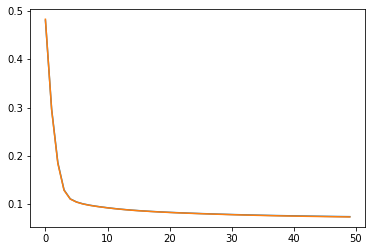

In [10]:
# TODO Plot the training and test error for each trainings iteration
train_loss = [loss[0] for loss in loss_history]
test_loss = [loss[1] for loss in loss_history]
steps = list(range(len(train_loss)))
plt.plot(steps, train_loss, label="train loss")
plt.plot(steps, test_loss, label="test loss")

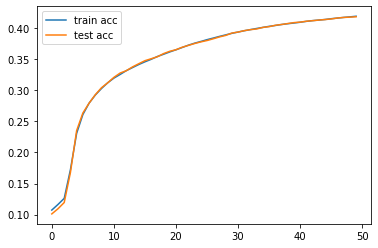

In [11]:
# TODO Plot the training and test error for each trainings iteration
train_acc = [acc[0] for acc in acc_history]
test_acc = [acc[1] for acc in acc_history]
steps = list(range(len(train_acc)))
plt.plot(steps, train_acc, label="train acc")
plt.plot(steps, test_acc, label="test acc")
plt.legend()

## Visualisierung der Gewichte
Im folgenden wird die Gewichtsmatrix visualisiert. Dadurch soll ersichtlich werden, was die Machine gelernt hat. Je nach Fehlerfunktion und Trainingsalgorithmus sind die entstehenen Bilder mehr oder weniger aufschlussreich für uns Menschen. Das aktuelle Model sollte nach langem training sehr verrauschte Gewichtsbilder liefern.



In [12]:
def plot_weights(w):
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    
    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<w.shape[1]:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i][:img_size_flat].reshape((28,28))

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='bwr')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

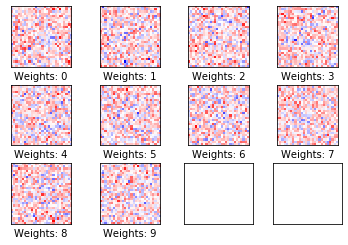

In [13]:
plot_weights(weights)

## Abgabe
Bevor sie das Notebook in Moodle hochladen entfernen sie bitte über "Kernel" -> "Restart and Clear Output" sämtlichen von Python erstellten Inhalt und speichern anschließend das Notebook "File" -> "Save and Checkpoint" erneut ab. Sorgen sie bitte außerdem dafür das im Dateinamen ihr Vor- und Nachname steht, ich empfehle folgende Namensgebung: "03_LogisticRegression_MNIST_VORNAME_NACHNAME.ipynb"